# Imports

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML

#https://pytorch.org/docs/master/nn.html
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Setting Hyperparameters

In [2]:
# Set the hyperparameters
batchSize = 128 # try 64, 128, 256
imageSize = 64 # (64 x 64)

beta1 = 0.5 # beta1 hyperparameter for Adam optimizers
lr = 0.0002 # learning rate

label_smoothing = 0.3 # best value: 0.3

epochs = 50

nz = 400 # size of the z latent vector (size of generator input) usually 100

device = "cuda:0"
ngpu = 1

# Importing and Preprocessing the Data

In [3]:
# Import CelebA dataset via torchvision.datasets and apply transformations to the images while loading it into the dataloader
transform = transforms.Compose([transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
dataset = dset.CelebA(root="./data", download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=2) # Load the data in batches and shuffle it.


Files already downloaded and verified


---
# Visualizing the Data

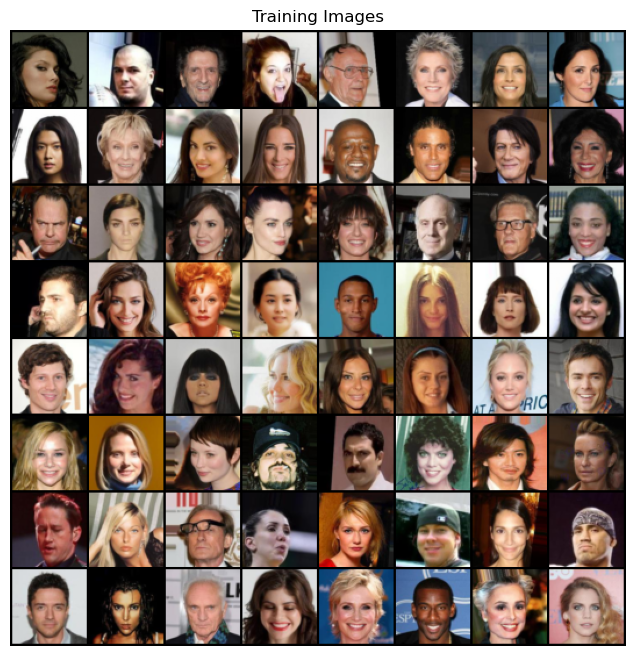

In [241]:
real_batch = next(iter(dataloader)) # Get a batch of real images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0))) 
plt.show()

# Defining the weights_init function
It takes as input a neural network m and initializes all its weights according to a normal distribution with mean 0 and standard deviation 0.02. The weights are initialized in place.

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1: # checks if the class is a convolutional layer
        m.weight.data.normal_(0.0, 0.02) # initializes the weights of the convolutional layer with a normal distribution with mean 0 and standard deviation 0.02
    elif classname.find("BatchNorm") != -1: # checks if the class is a batch normalization layer
        m.weight.data.normal_(1.0, 0.02) 

        m.bias.data.fill_(0)

---
# Defining the Generator

In [5]:
class G(nn.Module):
    def __init__(self, ngpu):
        super(G, self).__init__() 
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #start with an inverse convolutional layer as the generator takes a random vector as input and outputs an image (unlike a convolutional layer which takes an image as input and outputs a vector)
            
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False), # 100 input channels, 512 feature maps in the output, 4 kernel size, 1 stride, 0 padding
            # Commonly used architecture for the generator to start with a random vector of size 100 while using 512 feature maps in the output
            # bias set to false since it seems to work better this way
            
            nn.BatchNorm2d(512), # batch normalization layer
            nn.ReLU(True), # activation function to break the linearity
            
            # 2nd inverse convolutional layer
            # Since the input is the output of the previous layer, the input channels are 512
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 3th inverse convolutional layer
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 4th inverse convolutional layer
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # 5th inverse convolutional layer
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), # Since the output image has 3 color channels
            nn.Tanh() # Hyperbolic tangent activation function to break the linearity and map the output to the range [-1, 1] as we want the same standard as the images in the dataset and the images become the input of the discriminator            
        )
        
    # forward propagation function which defines how the data flows through the network
    def forward(self, input):
        return self.main(input)
    
    

# Creating the Generator

In [6]:
netG = G(ngpu).to(device) # Create the generator
netG.apply(weights_init) # Initialize the weights of the generator

G(
  (main): Sequential(
    (0): ConvTranspose2d(400, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

---
# Defining the Discriminator

In [7]:
class D(nn.Module):
    def __init__(self, ngpu):
        super(D, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Since it is a discriminator, we start with a convolutional layer as it takes an image as input and outputs a vector
            # input of this layer is the output of the generator
            nn.Conv2d(3,64,4,2,1, bias=False), # 3 input channels, 64 feature maps in the output, 4 kernel size, 2 stride, 1 padding
            nn.LeakyReLU(0.2, inplace=True), # Leaky ReLU activation function to break the linearity
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False), # 1 output channel
            nn.Sigmoid() # Sigmoid function as the output of the discriminator should be probabilistic
        )
        



    def forward(self, input):
        return self.main(input).view(-1) # Flatten the output tensor to a vector
        # Flattens the result of the convolutions that are 2D into a 1D
        # Todo tensors vs. vectors

    

# Creating the Discriminator

In [8]:
netD = D(ngpu).to(device) # Create the discriminator
netD.apply(weights_init) # Initialize the weights of the discriminator

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

---
# Loss Functions and Optimizers

In [9]:
# Criterion measures the error of the discriminator
criterion = nn.BCELoss() # Binary Cross Entropy Loss (ideal for binary classification problems and GANs)

fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Random noise

# Establish convention for real and fake labels during training
real_label = 1 - label_smoothing # 0.9 instead of 1 for label smoothing
fake_label = 0 + label_smoothing # 0.1 instead of 0 for label smoothing

# Optimizer for the discriminator and the generator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

'''
# Scheduler for the learning rate
schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=lr_step, gamma=gamma)
schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=lr_step, gamma=gamma)
'''

'\n# Scheduler for the learning rate\nschedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=lr_step, gamma=gamma)\nschedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=lr_step, gamma=gamma)\n'

---
# Training the DCGAN
1. Update the weights of the discriminator by backpropagating the error through the discriminator's network.
2. Update the weights of the generator by backpropagating the error through the generator's network.

In [249]:
img_list = []
G_losses = []
D_losses = []
iters = 0

# Training the DCGAN
print("Starting Training Loop...")

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # 1st Step: Updating the weights of the discriminator
        netD.zero_grad() # Initialize the gradients of the discriminator to zero
        
        # Training the discriminator with a real image of the dataset
        real_cpu = data[0].to(device) # Load the real images from the dataset
        b_size = real_cpu.size(0) # Get the batch size of the real images
        target = torch.full((b_size,), real_label, dtype=torch.float, device=device) # Since we train the discriminator with real images, the target is 1
        output = netD(real_cpu) # Forward propagation of the real images through the discriminator
        errD_real = criterion(output, target)
        errD_real.backward() # Backpropagate the error
        D_x = output.mean().item() # Compute the average of the output of the discriminator

        # Training the discriminator with a fake image generated by the generator
        noise = torch.randn(b_size, nz, 1, 1, device=device) # Generate random noise
        fake = netG(noise) # Generate a fake image from the random noise
        target.fill_(fake_label) # Since we train the discriminator with fake images, the target is 0
        output = netD(fake.detach()) # detach the gradient of the fake images as we don't want to update the weights of the generator
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD_fake.backward()
        D_G_z1 = output.mean().item() # Compute the average of the output of the discriminator
        errD = errD_real + errD_fake # Total error of the discriminator
        optimizerD.step() # Update the weights of the discriminator according to how much they are responsible for the total loss error
        
        
        # 2nd Step: Updating the weights of the generator: maximize log(D(G(z)))
        netG.zero_grad() # Initialize the gradients of the generator to zero
        target.fill_(real_label) # The target is 1 since we want the generator to create images that the discriminator classifies as real
        output = netD(fake)
        errG = criterion(output, target)
        
        errG.backward() # compute the gradients of the generator
        D_G_z2 = output.mean().item() # Compute the average of the output of the discriminator
        optimizerG.step() # Update the weights of the generator
        
        
        '''
        # Decrease the learning rate
        schedulerD.step()
        schedulerG.step()
        '''
        
        # Output traning stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # Save the losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
         

Starting Training Loop...
[0/50][0/1272] Loss_D: 1.9321 Loss_G: 1.7482 D(x): 0.3285 D(G(z)): 0.5390 / 0.1102
[0/50][50/1272] Loss_D: 1.3910 Loss_G: 1.7777 D(x): 0.6606 D(G(z)): 0.4335 / 0.0870
[0/50][100/1272] Loss_D: 1.2867 Loss_G: 0.6179 D(x): 0.6922 D(G(z)): 0.2222 / 0.6912
[0/50][150/1272] Loss_D: 1.5212 Loss_G: 0.6742 D(x): 0.7069 D(G(z)): 0.0614 / 0.8381
[0/50][200/1272] Loss_D: 1.3953 Loss_G: 3.0895 D(x): 0.7140 D(G(z)): 0.5701 / 0.0124
[0/50][250/1272] Loss_D: 1.2456 Loss_G: 1.4408 D(x): 0.6963 D(G(z)): 0.3477 / 0.1365
[0/50][300/1272] Loss_D: 1.5892 Loss_G: 2.4960 D(x): 0.7378 D(G(z)): 0.7027 / 0.0289
[0/50][350/1272] Loss_D: 1.2381 Loss_G: 1.3577 D(x): 0.7013 D(G(z)): 0.3489 / 0.1559
[0/50][400/1272] Loss_D: 2.3652 Loss_G: 2.6848 D(x): 0.4771 D(G(z)): 0.0052 / 0.0221
[0/50][450/1272] Loss_D: 1.6497 Loss_G: 1.4102 D(x): 0.6086 D(G(z)): 0.0427 / 0.1429
[0/50][500/1272] Loss_D: 1.5528 Loss_G: 0.7887 D(x): 0.6380 D(G(z)): 0.0581 / 0.4073
[0/50][550/1272] Loss_D: 1.6722 Loss_G: 1.

# Saving the model

In [240]:
torch.save(netG.state_dict(), './models/DCGAN-7.pth')

---
# Visualizing the Losses

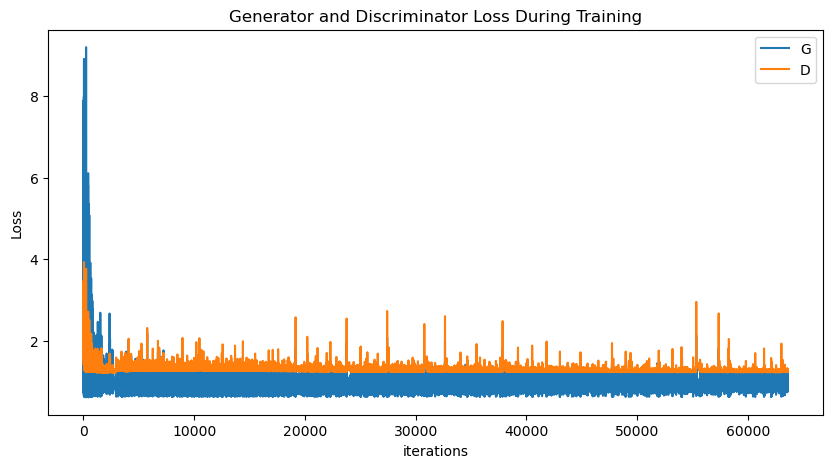

In [250]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualizing the generators progression

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


# Real vs. Fake Images

In [2]:
real_batch = next(iter(dataloader)) # Get a batch of real images

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

NameError: name 'dataloader' is not defined